In [43]:
import numpyro as npy
import jax.numpy as jnp
import jax.random as random
import numpy as np
import plotly.express as px
import plotly.io as pio
import arviz as az

In [2]:
pio.renderers.default = "svg"

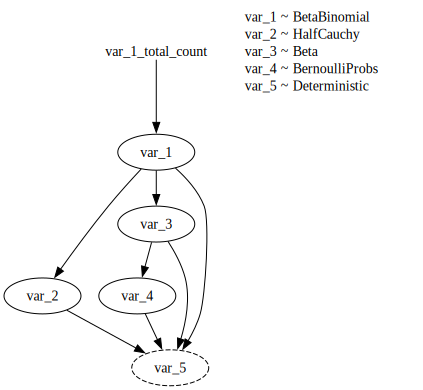

In [39]:
def model():
    var_1_total_count = npy.param(
        name="var_1_total_count",
        init_value=30
    )

    var_1 = npy.sample(
        name="var_1",
        fn=npy.distributions.BetaBinomial(
            concentration1=0.5,
            concentration0=0.5,
            total_count=var_1_total_count
        )
    )

    var_2 = npy.sample(
        name="var_2",
        fn=npy.distributions.HalfCauchy(
            scale=var_1
        )
    )

    var_3 = npy.sample(
        name="var_3",
        fn=npy.distributions.Beta(
            concentration0=var_1,
            concentration1=2
        )
    )

    var_4 = npy.sample(
        name="var_4",
        fn=npy.distributions.Bernoulli(
            probs=var_3
        )
    )

    var_5 = npy.deterministic(
        name="var_5",
        value=jnp.where(
            var_1 > 20,
            (var_1 + var_2 * var_3 * var_4)**2,
            var_1 + var_2 * var_3 * var_4
        )
    )

    return None

npy.render_model(
    model=model,
    render_distributions=True,
    render_params=True
)

In [40]:
hmc_kernel = npy.infer.HMC(model=model)

mixed_hmc = npy.infer.MixedHMC(
    inner_kernel=hmc_kernel   
)

mcmc = npy.infer.MCMC(
    sampler=mixed_hmc,
    num_warmup=100,
    num_samples=100,
    num_chains=4
)

# Run the MCMC sampler and collect samples
mcmc.run(
    rng_key=random.PRNGKey(seed=42)
)

/tmp/ipykernel_76070/3617518464.py:7: UserWarning:

There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.

sample: 100%|██████████| 200/200 [00:00<00:00, 2476.48it/s, 17 steps of size 4.08e-01. acc. prob=0.96]


In [41]:
model_samples = mcmc.get_samples()

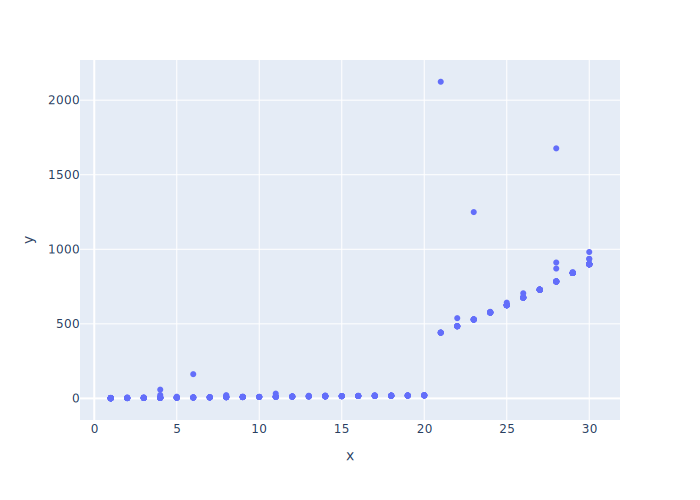

In [42]:
px.scatter(
    x=model_samples["var_1"],
    y=model_samples["var_5"]
)

array([[<Axes: title={'center': 'var_1'}>,
        <Axes: title={'center': 'var_2'}>,
        <Axes: title={'center': 'var_3'}>],
       [<Axes: title={'center': 'var_4'}>,
        <Axes: title={'center': 'var_5'}>, <Axes: >]], dtype=object)

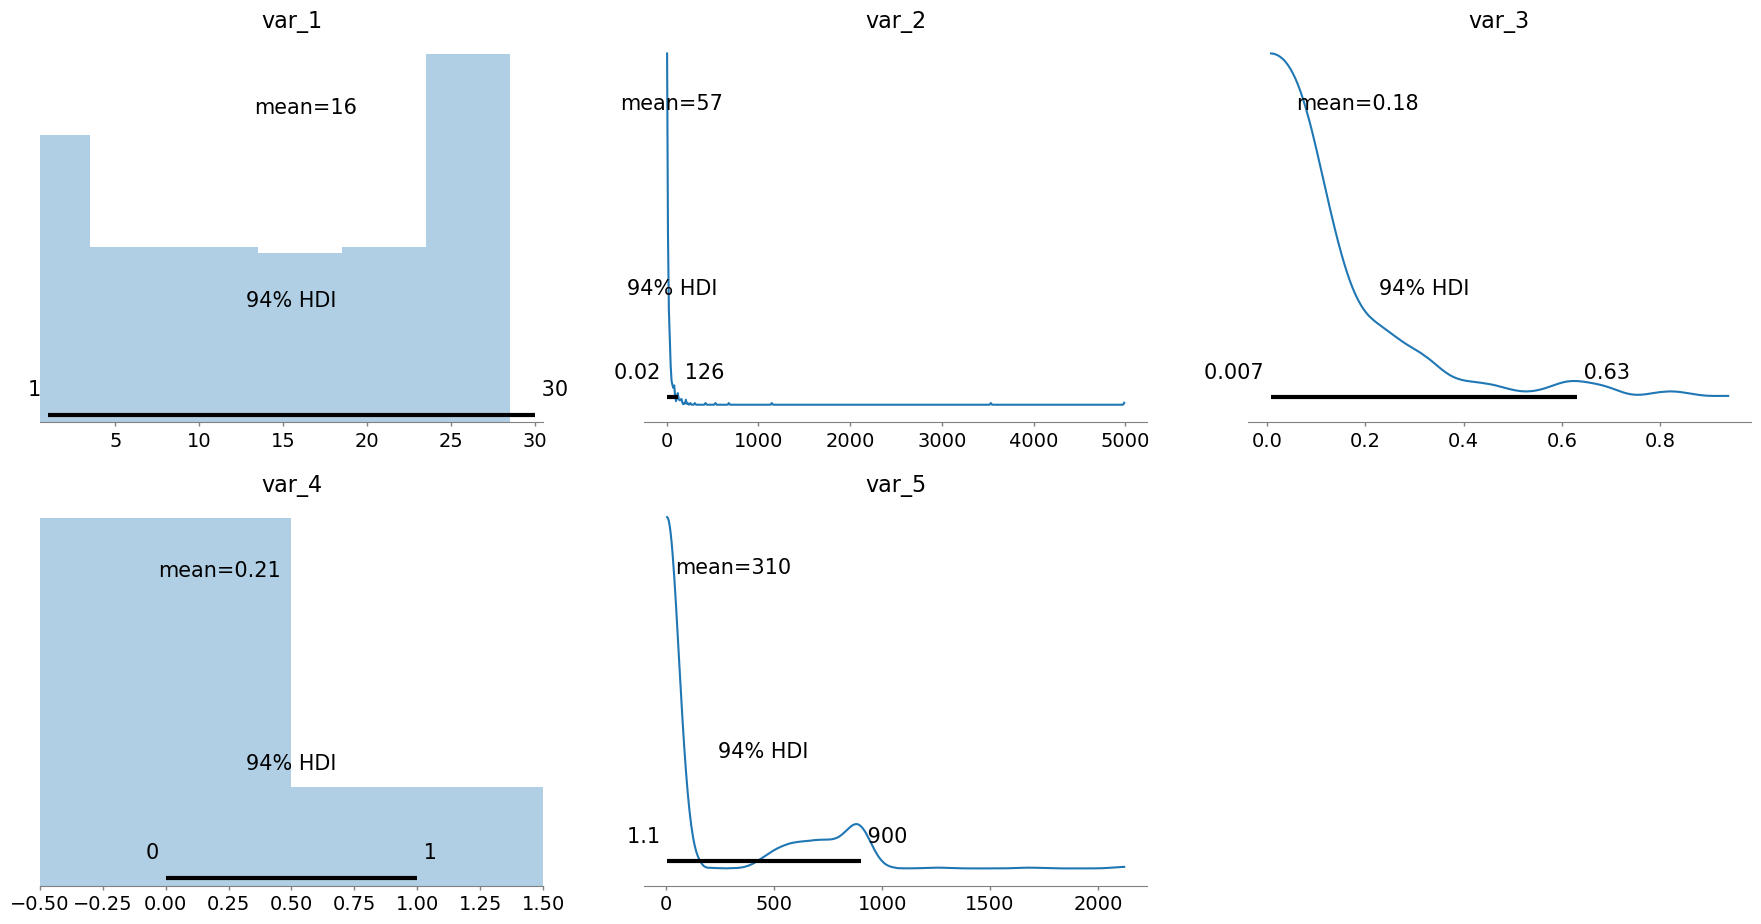

In [48]:
az_model = az.from_numpyro(posterior=mcmc)
az.plot_posterior(az_model.posterior)